In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate, ZeroPadding2D

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [2]:
currentPath = os.getcwd()
print(currentPath)

C:\Users\CARLOS CORDERO\Desktop\ToG_pretrain


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


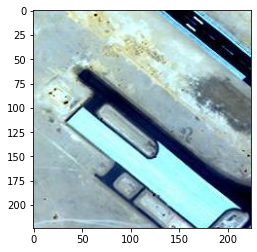

In [4]:
trainDB = currentPath + os.sep + "train20"
valDB = currentPath + os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
DenseNetWeightsPretrained = currentPath + os.sep + "DenseNet-BC-161-48-no-top.h5"
model_name = "DenseNet-161"
classList = os.listdir(trainDB)

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_18_0_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00016
batch_size = 10
num_epochs = 200
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 224, 224, 3
num_categories = len(classList)

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 925 images belonging to 62 classes.
Found 309 images belonging to 62 classes.


In [7]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6, 'border_checkpoint': 7, 'burial_site': 8, 'car_dealership': 9, 'construction_site': 10, 'crop_field': 11, 'dam': 12, 'debris_or_rubble': 13, 'educational_institution': 14, 'electric_substation': 15, 'factory_or_powerplant': 16, 'fire_station': 17, 'flooded_road': 18, 'fountain': 19, 'gas_station': 20, 'golf_course': 21, 'ground_transportation_station': 22, 'helipad': 23, 'hospital': 24, 'impoverished_settlement': 25, 'interchange': 26, 'lake_or_pond': 27, 'lighthouse': 28, 'military_facility': 29, 'multi-unit_residential': 30, 'nuclear_powerplant': 31, 'office_building': 32, 'oil_or_gas_facility': 33, 'park': 34, 'parking_lot_or_garage': 35, 'place_of_worship': 36, 'police_station': 37, 'port': 38, 'prison': 39, 'race_track': 40, 'railway_bridge': 41, 'recreational_facility': 42, 'road_bridge': 43, 'runway': 44, 'shipyard': 45, 'shopping_mall': 46, 'sin

In [8]:
convcnt = 1
def bn_relu_conv(x, filters, kernel_size):
    global convcnt
    convcnt = convcnt + 1
    x = BatchNormalization(name= "batch_normalization_"+str(convcnt))(x)
    x = ReLU()(x) 
    x = Conv2D(filters, kernel_size, padding="same", name= "conv2d_"+str(convcnt), use_bias=False)(x)
    return x

In [9]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_relu_conv(tensor, 4*k, 1)
        x = bn_relu_conv(x, k, 3)
        tensor = Concatenate()([tensor, x])
    return tensor

In [10]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = bn_relu_conv(x, f, 1)
    x = AvgPool2D(2, strides=2, padding="same")(x)
    return x

In [11]:
def densenet_161( imageShape, weights):
    k = 48
    theta = 0.5
    repetitions = [6, 12, 36, 24]

    input = Input(shape=(imageShape))
    x = ZeroPadding2D(padding=(3, 3))(input)
    x = Conv2D(2*k, 7, strides=2, padding="valid", name="conv2d_1", use_bias=False)(x)
    x = BatchNormalization(name= "batch_normalization_input")(x)
    x = ReLU()(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPool2D(3, strides=2, padding="valid")(x)

    for reps in repetitions:
        denseBlock = dense_block(x, k, reps)
        x = transition_layer(denseBlock, theta)

    model = Model(input, denseBlock)
    model.load_weights(weights, by_name=True)
    
    x = GlobalAvgPool2D()(denseBlock)
    output = Dense(num_categories, activation="softmax")(x)
    model = Model(input, output)
        
    return model



In [12]:
model = densenet_161((img_rows, img_cols, img_channel), DenseNetWeightsPretrained)

model.summary()
#plot_model(model, show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 96) 14112       zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_input (Batc (None, 112, 112, 96) 384         conv2d_1[0][0]                   
____________________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_125 (BatchN (None, 7, 7, 1344)   5376        concatenate_59[0][0]             
__________________________________________________________________________________________________
re_lu_124 (ReLU)                (None, 7, 7, 1344)   0           batch_normalization_125[0][0]    
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 7, 7, 192)    258048      re_lu_124[0][0]                  
__________________________________________________________________________________________________
batch_normalization_126 (BatchN (None, 7, 7, 192)    768         conv2d_125[0][0]                 
__________________________________________________________________________________________________
re_lu_125 (ReLU)                (None, 7, 7, 192)    0           batch_normalization_126[0][0]    
__________

In [13]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    callbacks=[ReduceLROnPlateau()],
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
4/4 [==============================] - 7s 2s/step - loss: 0.0826 - accuracy: 0.0500 - val_loss: 0.0825 - val_accuracy: 0.0250 - lr: 1.6000e-04
Epoch 2/200
4/4 [==============================] - 2s 564ms/step - loss: 0.0828 - accuracy: 0.0000e+00 - val_loss: 0.0828 - val_accuracy: 0.0000e+00 - lr: 1.6000e-04
Epoch 3/200
4/4 [==============================] - 2s 554ms/step - loss: 0.0826 - accuracy: 0.0000e+00 - val_loss: 0.0825 - val_accuracy: 0.0000e+00 - lr: 1.6000e-04
Epoch 4/200
4/4 [==============================] - 2s 555ms/step - loss: 0.0827 - accuracy: 0.0000e+00 - val_loss: 0.0828 - val_accuracy: 0.0250 - lr: 1.6000e-04
Epoch 5/200
4/4 [==============================] - 2s 561ms/step - loss: 0.0826 - accuracy: 0.0250 - val_loss: 0.0823 - val_accuracy: 0.0250 - lr: 1.6000e-04
Epoch 6/200
4/4 [==============================] - 2s 558ms/step - loss: 0.0826 - accuracy: 0.0000e+00 - val_loss: 0.

Epoch 50/200
4/4 [==============================] - 2s 501ms/step - loss: 0.0805 - accuracy: 0.0750 - val_loss: 0.0818 - val_accuracy: 0.0256 - lr: 1.6000e-06
Epoch 51/200
4/4 [==============================] - 2s 505ms/step - loss: 0.0816 - accuracy: 0.0000e+00 - val_loss: 0.0818 - val_accuracy: 0.0000e+00 - lr: 1.6000e-06
Epoch 52/200
4/4 [==============================] - 2s 508ms/step - loss: 0.0808 - accuracy: 0.1000 - val_loss: 0.0823 - val_accuracy: 0.0000e+00 - lr: 1.6000e-06
Epoch 53/200
4/4 [==============================] - 2s 502ms/step - loss: 0.0810 - accuracy: 0.0000e+00 - val_loss: 0.0826 - val_accuracy: 0.0000e+00 - lr: 1.6000e-06
Epoch 54/200
4/4 [==============================] - 2s 506ms/step - loss: 0.0811 - accuracy: 0.0500 - val_loss: 0.0810 - val_accuracy: 0.0500 - lr: 1.6000e-06
Epoch 55/200
4/4 [==============================] - 2s 504ms/step - loss: 0.0804 - accuracy: 0.0750 - val_loss: 0.0820 - val_accuracy: 0.0000e+00 - lr: 1.6000e-06
Epoch 56/200
4/4 [====

Epoch 101/200
4/4 [==============================] - 2s 508ms/step - loss: 0.0806 - accuracy: 0.0750 - val_loss: 0.0822 - val_accuracy: 0.0250 - lr: 1.6000e-11
Epoch 102/200
4/4 [==============================] - 2s 508ms/step - loss: 0.0806 - accuracy: 0.0750 - val_loss: 0.0819 - val_accuracy: 0.0000e+00 - lr: 1.6000e-11
Epoch 103/200
4/4 [==============================] - 2s 508ms/step - loss: 0.0809 - accuracy: 0.0000e+00 - val_loss: 0.0822 - val_accuracy: 0.0250 - lr: 1.6000e-11
Epoch 104/200
4/4 [==============================] - 2s 508ms/step - loss: 0.0820 - accuracy: 0.0000e+00 - val_loss: 0.0819 - val_accuracy: 0.0000e+00 - lr: 1.6000e-11
Epoch 105/200
4/4 [==============================] - 2s 508ms/step - loss: 0.0808 - accuracy: 0.0750 - val_loss: 0.0815 - val_accuracy: 0.0500 - lr: 1.6000e-11
Epoch 106/200
4/4 [==============================] - 2s 504ms/step - loss: 0.0808 - accuracy: 0.1000 - val_loss: 0.0819 - val_accuracy: 0.0000e+00 - lr: 1.6000e-11
Epoch 107/200
4/4 [=

Epoch 152/200
4/4 [==============================] - 2s 508ms/step - loss: 0.0814 - accuracy: 0.0750 - val_loss: 0.0805 - val_accuracy: 0.0750 - lr: 1.6000e-15
Epoch 153/200
4/4 [==============================] - 2s 510ms/step - loss: 0.0810 - accuracy: 0.0250 - val_loss: 0.0810 - val_accuracy: 0.0500 - lr: 1.6000e-15
Epoch 154/200
4/4 [==============================] - 2s 510ms/step - loss: 0.0809 - accuracy: 0.0750 - val_loss: 0.0812 - val_accuracy: 0.1250 - lr: 1.6000e-15
Epoch 155/200
4/4 [==============================] - 2s 511ms/step - loss: 0.0809 - accuracy: 0.0250 - val_loss: 0.0813 - val_accuracy: 0.0250 - lr: 1.6000e-15
Epoch 156/200
4/4 [==============================] - 2s 509ms/step - loss: 0.0812 - accuracy: 0.0750 - val_loss: 0.0807 - val_accuracy: 0.1000 - lr: 1.6000e-15
Epoch 157/200
4/4 [==============================] - 2s 510ms/step - loss: 0.0808 - accuracy: 0.1000 - val_loss: 0.0813 - val_accuracy: 0.0250 - lr: 1.6000e-15
Epoch 158/200
4/4 [=====================

In [15]:
model.save(currentPath + os.sep + "DenseNet161Model.h5")
model.save_weights(currentPath + os.sep + "DenseNet161Weights.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


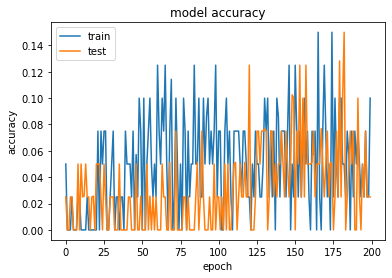

In [16]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

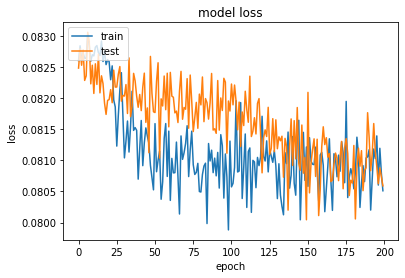

In [17]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [18]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( 224, 224))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_11_6_msrgb.jpg is: runway
file airport_11_7_msrgb.jpg is: runway
file airport_17_4_msrgb.jpg is: amusement_park
file airport_25_0_msrgb.jpg is: impoverished_settlement
file airport_3_5_msrgb.jpg is: amusement_park


In [19]:
loadedModel = load_model("DenseNet161Model.h5")

path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( 224, 224))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_11_6_msrgb.jpg is: runway
file airport_11_7_msrgb.jpg is: runway
file airport_17_4_msrgb.jpg is: amusement_park
file airport_25_0_msrgb.jpg is: impoverished_settlement
file airport_3_5_msrgb.jpg is: amusement_park
